In [1]:
import pandas as pd

import re
import time
import nltk
import joblib

from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

import matplotlib.pyplot as plt

start = time.time()

# Chargement des données
file_path = '/home/vatosoa/mg-smart-lingua-discover/data/corpus/fki.csv'
data = pd.read_csv(file_path) 
data.columns = ['text', 'summary']

# Prétraitement des données
def text_cleaner(text, stopwords):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'\n', ' ', text)  # Remove newline characters
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    text = re.sub(r'\([^)]*\)', '', text)  # Remove text between parentheses
    text = re.sub('[^a-zA-Z]', ' ', text)  # Remove non-alphabetic characters
    text = ' '.join([word for word in text.split() if word.lower() not in stopwords])  # Remove stopwords
    return text.lower().strip()

# Chargement des stopwords pour le malgache
stopwords_file_path = '/home/vatosoa/mg-smart-lingua-discover/data/corpus/stopwords.txt'
with open(stopwords_file_path, 'r', encoding='utf-8') as file:
    stop_words = set(file.read().splitlines())

data['cleaned_text'] = data['text'].apply(lambda x: text_cleaner(x, stop_words))
data['cleaned_summary'] = data['summary'].apply(lambda x: text_cleaner(x, stop_words))


2024-01-24 10:29:45.894483: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-24 10:29:49.114324: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-24 10:29:49.114395: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-24 10:29:49.135363: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-24 10:29:51.067311: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-24 10:29:51.071268: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [2]:
# Séparation des données en ensembles d'entraînement et de validation
x_tr, x_val, y_tr, y_val = train_test_split(data['cleaned_text'], data['cleaned_summary'], test_size=0.1, random_state=0, shuffle=True)


# Tokenisation des textes
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))


thresh = 4

cnt = 0
tot_cnt = 0
freq = 0
tot_freq = 0

for key, value in x_tokenizer.word_counts.items():
    tot_cnt += 1
    tot_freq += value
    if value < thresh:
        cnt += 1
        freq += value

print("% de mots rares dans le vocabulaire:", (cnt/tot_cnt)*100)
print("Couverture totale des mots rares:", (freq/tot_freq)*100)

x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

x_tr_seq = x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq = x_tokenizer.texts_to_sequences(x_val)

max_text_len = 100
x_tr = pad_sequences(x_tr_seq, maxlen=max_text_len, padding='post')
x_val = pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

x_voc = x_tokenizer.num_words + 1

# Tokenisation des résumés
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

thresh = 6

cnt = 0
tot_cnt = 0
freq = 0
tot_freq = 0

for key, value in y_tokenizer.word_counts.items():
    tot_cnt += 1
    tot_freq += value
    if value < thresh:
        cnt += 1
        freq += value

print("% de mots rares dans le vocabulaire:", (cnt/tot_cnt)*100)
print("Couverture totale des mots rares:", (freq/tot_freq)*100)

y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

y_tr_seq = y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq = y_tokenizer.texts_to_sequences(y_val) 

max_summary_len = 15
y_tr = pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val = pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

y_voc = y_tokenizer.num_words + 1

import numpy as np

# Suppression des exemples avec des résumés vides (qui ont été transformés en séquences avec seulement 2 mots)
ind = []
for i in range(len(y_tr)):
    cnt = 0
    for j in y_tr[i]:
        if j != 0:
            cnt += 1
    if cnt <= 1:  # Change la condition pour inclure des résumés de 3 mots ou plus
        ind.append(i)

y_tr = np.delete(y_tr, ind, axis=0)
x_tr = np.delete(x_tr, ind, axis=0)

ind = []
for i in range(len(y_val)):
    cnt = 0
    for j in y_val[i]:
        if j != 0:
            cnt += 1
    if cnt <= 1:  # Change la condition pour inclure des résumés de 3 mots ou plus
        ind.append(i)

y_val = np.delete(y_val, ind, axis=0)
x_val = np.delete(x_val, ind, axis=0)



% de mots rares dans le vocabulaire: 80.76923076923077
Couverture totale des mots rares: 48.837209302325576
% de mots rares dans le vocabulaire: 88.57142857142857
Couverture totale des mots rares: 50.92592592592593


In [3]:
# Création du modèle Seq2Seq avec LSTM
latent_dim = 300
embedding_dim = 200

encoder_inputs = Input(shape=(max_text_len,))
enc_emb = Embedding(x_voc, embedding_dim, trainable=True)(encoder_inputs)
encoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)
encoder_lstm2 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)
encoder_lstm3 = LSTM(latent_dim, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(y_voc, embedding_dim, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb, initial_state=[state_h, state_c])
decoder_dense = TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

# Définition du modèle d'encodage seul
encoder_model = Model(encoder_inputs, [encoder_outputs, state_h, state_c])

# Définition du modèle de décodage seul
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder_lstm(
    dec_emb, initial_state=decoder_states_inputs)

decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)




In [4]:
# Récupération des index inverses pour la tokenisation du texte d'entrée
reverse_source_word_index = dict((i, word) for word, i in x_tokenizer.word_index.items())

# Récupération des index inverses pour la tokenisation du résumé de sortie
reverse_target_word_index = dict((i, word) for word, i in y_tokenizer.word_index.items())



# Entraînement du modèle avec EarlyStopping
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)


mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)


history = model.fit(
    [x_tr, y_tr[:, :-1]],
    y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:, 1:],
    epochs=50,
    callbacks=[es, mc],  # Ajoutez le callback ModelCheckpoint
    batch_size=128,
    validation_data=([x_val, y_val[:, :-1]], y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:, 1:])
)



Epoch 1/50
1/1 [==============================] - ETA: 0s - loss: 1.6210

/home/vatosoa/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 65s 65s/step - loss: 1.6210 - val_loss: 1.3180
Epoch 2/50
1/1 [==============================] - 15s 15s/step - loss: 1.3412 - val_loss: 0.6766
Epoch 3/50
1/1 [==============================] - 11s 11s/step - loss: 0.7628 - val_loss: 0.3810
Epoch 4/50
1/1 [==============================] - 14s 14s/step - loss: 0.6690 - val_loss: 0.4722
Epoch 5/50
1/1 [==============================] - 13s 13s/step - loss: 0.3793 - val_loss: 0.1722
Epoch 6/50
1/1 [==============================] - 8s 8s/step - loss: 0.4330 - val_loss: 0.1041
Epoch 7/50
1/1 [==============================] - 8s 8s/step - loss: 0.2133 - val_loss: 0.1491
Epoch 8/50
1/1 [==============================] - 12s 12s/step - loss: 0.1810 - val_loss: 0.1573
Epoch 9/50
1/1 [==============================] - 7s 7s/step - loss: 0.1693 - val_loss: 0.1602
Epoch 10/50
1/1 [==============================] - 5s 5s/step - loss: 0.1639 - val_loss: 0.1585
Epoch 11/50
1/1 [==============================]

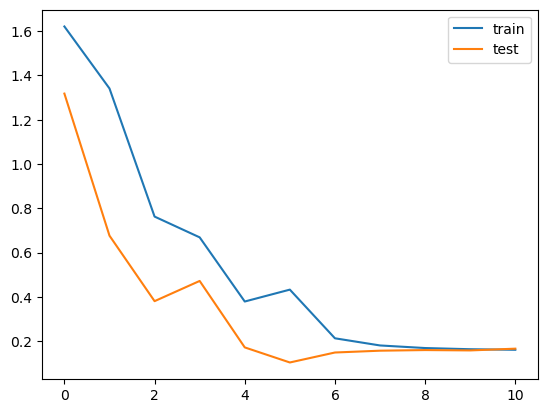

In [5]:
# Affichage des courbes d'apprentissage
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


In [6]:
# Fonction de décodage pour générer des prédictions
def decode_sequence(input_seq):
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = y_tokenizer.word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq, e_h, e_c])

        sampled_token_index = np.argmax(output_tokens[0, -1, :])

        if sampled_token_index not in reverse_target_word_index:
            # Vérification pour éviter KeyError
            stop_condition = True
        elif sampled_token_index == y_tokenizer.word_index['eostok'] or len(decoded_sentence.split()) >= (max_summary_len-1):
            stop_condition = True
        else:
            sampled_token = reverse_target_word_index[sampled_token_index]
            decoded_sentence += ' ' + sampled_token

        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        e_h, e_c = h, c

    return decoded_sentence.strip()


# Fonctions pour convertir les séquences en texte lisible
def seq2summary(input_seq):
    new_string = ''
    for i in input_seq:
        if i != 0 and i != y_tokenizer.word_index['sostok'] and i != y_tokenizer.word_index['eostok']:
            new_string += reverse_target_word_index[i] + ' '
    return new_string


def seq2text(input_seq):
    new_string = ''
    for i in input_seq:
        if i != 0:
            new_string += reverse_source_word_index[i] + ' '
    return new_string



In [7]:
# Testez votre modèle sur des exemples d'entraînement
for i in range(0, 15):
    print("Review:", seq2text(x_tr[i]))
    print("Original summary:", seq2summary(y_tr[i]))
    print("Predicted summary:", decode_sequence(x_tr[i].reshape(1, max_text_len)))
    print("\n")

# Utilisez la fonction `decode_sequence` pour générer des résumés pour de nouvelles données
new_data = ["Andriamanitra nanao hoe misia ny mazava dia nisy izany.",
           #autre
           ]
new_data_sequences = x_tokenizer.texts_to_sequences(new_data)
new_data_padded = pad_sequences(new_data_sequences, maxlen=max_text_len, padding='post')

for i in range(len(new_data)):
    print("Review:", new_data[i])
    print("Predicted summary:", decode_sequence(new_data_padded[i].reshape(1, max_text_len)))
    print("\n")

Review: andriamanitra nanao rano habakabaka rano habakabaka nisy 
Original summary: andriamanitra 
1/1 [==============================] - 0s 52ms/step
Predicted summary: andriamanitra


Review: nisy nisy andro 
Original summary: 
1/1 [==============================] - 0s 42ms/step
Predicted summary: andriamanitra


Review: andriamanitra nanao tany mamoa mamoa tany nisy 
Original summary: andriamanitra 
1/1 [==============================] - 0s 42ms/step
Predicted summary: andriamanitra


Review: andriamanitra mazava andriamanitra mazava 
Original summary: andriamanitra andriamanitra 
1/1 [==============================] - 0s 47ms/step
Predicted summary: andriamanitra


Review: andriamanitra rano 
Original summary: andriamanitra 
1/1 [==============================] - 0s 64ms/step
Predicted summary: andriamanitra


Review: nisy nisy andro 
Original summary: 
1/1 [==============================] - 0s 69ms/step
Predicted summary: andriamanitra


Review: andriamanitra nanao andro andro 
Or

In [8]:
# Utiliser la fonction `decode_sequence` pour générer des résumés prédits
predicted_summaries = []
for i in range(len(data)):
    input_review = data['text'][i]
    original_summary = data['summary'][i]
    input_sequence = x_tokenizer.texts_to_sequences([input_review])[0]
    input_sequence_padded = pad_sequences([input_sequence], maxlen=max_text_len, padding='post')
    predicted_summary = decode_sequence(input_sequence_padded)
    predicted_summaries.append(predicted_summary)

# Afficher les résultats
for i in range(len(data)):
    print("Review:", data['text'][i])
    print("Original summary:", data['summary'][i])
    print("Predicted summary:", predicted_summaries[i])
    print("\n")

1/1 [==============================] - 0s 37ms/step
Review: Tamin'ny voalohany Andriamanitra nahary ny lanitra sy ny tany.
Original summary: sostok Andriamanitra nahary ny lanitra sy ny tany. eostok
Predicted summary: andriamanitra


Review: Ary ny tany dia tsy nisy endrika sady foana; ary aizina no tambonin'ny lalina.
Original summary: sostok ny tany dia tsy nisy endrika. eostok
Predicted summary: andriamanitra


Review: Ary ny fanahin'Andriamanitra nanomba tambonin'ny rano.
Original summary: sostok ny fanahin'Andriamanitra nanomba ny rano. eostok
Predicted summary: andriamanitra


Review: Ary Andriamanitra nanao hoe: Misia mazava; dia nisy mazava.
Original summary: sostok Andriamanitra nanao hoe miasa mazava dia nisy. eostok
Predicted summary: andriamanitra


Review: Ary hitan'Andriamanitra fa tsara ny mazava; ary nampisarahin'Andriamanitra ny mazava sy ny maizina.
Original summary: sostok hitan'Andriamanitra fa tsara mazava; ary nampisarahin'Andriamanitra ny mazava sy ny maizina. eo

In [9]:
# Exemple de prédiction pour une phrase donnée
input_text = "Hitan'Andriamanitra fa tsara izany."

# Prétraitement de la phrase d'entrée
cleaned_input_text = text_cleaner(input_text, stop_words)

# Tokenisation de la phrase d'entrée
input_sequence = x_tokenizer.texts_to_sequences([cleaned_input_text])[0]
input_sequence_padded = pad_sequences([input_sequence], maxlen=max_text_len, padding='post')

# Utilisation de la fonction decode_sequence pour générer la prédiction
predicted_summary = decode_sequence(input_sequence_padded)

# Affichage des résultats
print("Input text:", input_text)
print("Predicted summary:", predicted_summary)


1/1 [==============================] - 0s 36ms/step
Input text: Hitan'Andriamanitra fa tsara izany.
Predicted summary: andriamanitra


In [16]:
# Sauvegarde de model, model-mg-structurevos.h5 est le modèle Keras
model.save('/home/vatosoa/mg-smart-lingua-discover/data/models/model-mg-summaryfki.h5')
encoder_model.save('/home/vatosoa/mg-smart-lingua-discover/data/models/encoder_mode-mg-summaryfki.h5')
decoder_model.save('/home/vatosoa/mg-smart-lingua-discover/data/models/decoder_model-mg-summaryfki.h5')

# Sauvegarde des Tokenizers
joblib.dump(x_tokenizer, '/home/vatosoa/mg-smart-lingua-discover/data/pretraining/mg-summaryfki/x_tokenizer.joblib')
joblib.dump(y_tokenizer, '/home/vatosoa/mg-smart-lingua-discover/data/pretraining/mg-summaryfki/y_tokenizer.joblib')

# Sauvegarde des configurations
model_config = {
    'max_text_len': max_text_len,
    'max_summary_len': max_summary_len,
    'x_voc': x_voc,
    'y_voc': y_voc,
}
joblib.dump(model_config, '/home/vatosoa/mg-smart-lingua-discover/data/pretraining/mg-summaryfki/model_config.joblib')

# Sauvegarde des fonctions
joblib.dump(text_cleaner, '/home/vatosoa/mg-smart-lingua-discover/data/functions/text_cleaner_function.joblib')
joblib.dump(decode_sequence, '/home/vatosoa/mg-smart-lingua-discover/data/functions/decode_sequence_function.joblib')
joblib.dump(seq2summary, '/home/vatosoa/mg-smart-lingua-discover/data/functions/seq2summary_function.joblib')
joblib.dump(seq2text, '/home/vatosoa/mg-smart-lingua-discover/data/functions/seq2text_function.joblib')


['/home/vatosoa/mg-smart-lingua-discover/data/functions/seq2text_function.joblib']

In [17]:
joblib.dump(reverse_source_word_index, '/home/vatosoa/mg-smart-lingua-discover/data/functions/reverse_source_word_index.joblib')
joblib.dump(reverse_target_word_index, '/home/vatosoa/mg-smart-lingua-discover/data/functions/reverse_target_word_index.joblib')

['/home/vatosoa/mg-smart-lingua-discover/data/functions/reverse_target_word_index.joblib']

In [18]:
end = time.time()
print(f"Total time required for all this = {end-start}")
print(f"Start = {start}")
print(f"End = {end}")

Total time required for all this = 458.1748378276825
Start = 1706081410.6947007
End = 1706081868.8695385
